In [8]:
import numpy as np
import pandas as pd
import sys, os
import random
from sklearn.preprocessing import normalize
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import MDS,TSNE
from umap import UMAP
from sklearn.cluster import KMeans
import re
from plotnine import *


seed = 20210118
np.random.seed(seed)
random.seed(seed)
# remove redundant antibodies

filter_out_abs = [
    'C002_Bloom',
    'C105_Bloom',
    'C121_Bloom',
    'C144_Bloom',
    'COV2-2130_Bloom',
    'COV2-2196_Bloom',
    'COV2-2479_Bloom',
    'COV2-2499_Bloom',
    'COV2-2955_Bloom',
    'LY-CoV016_Bloom',
    'LY-CoV555_Bloom',
    'REGN10933_Bloom',
    'REGN10987_Bloom',
    'S2E12_Bloom',
    'S2H13_Bloom',
    'S2H14_Bloom',
    'S2H97_Bloom',
    'S2X259_Bloom',
    'COV2-2677_Bloom',
    'S2X35_Bloom',
    'S304_Bloom',
    'S309_Bloom',
    'C110_Bloom',
]


In [9]:
# load data
use_data_site = pd.read_csv("data/site_scores_all_expr_passQC.csv")
use_data_mut = pd.read_csv("data/mut_scores_all_expr_passQC.csv")

# add bloom data
bloom_data = pd.read_csv("data/site_scores_from_JBloom.csv").query('antibody not in @filter_out_abs')

use_data_add = pd.concat([use_data_site,bloom_data])

site_mat = use_data_add.groupby(['antibody','site']).mean().reset_index().pivot(index='antibody', columns='site', values='site_total_escape').fillna(0)

# add omitted zero-scored rows to generate proper average scores
use_res = (use_data_mut
           .pivot(index=['antibody','condition', 'site'], columns='mutation', values='mut_escape')
           .fillna(0)
           .melt(var_name='mutation', value_name='mut_escape', ignore_index=False)
           .reset_index()
           .groupby(['antibody','site', 'mutation'])
           .mean()
           .reset_index())


In [10]:

site_mat_norm = normalize(VarianceThreshold(0.1).fit_transform(site_mat), axis=0, norm='l2')
dis_mat = 1.0 - np.corrcoef(site_mat_norm)
print(site_mat.shape)
print(site_mat_norm.shape)


(1538, 181)
(1538, 92)


In [16]:

def get_tsne(dis_mat, AbNames, seed=20220408, mds_comp=20, perplexity=35, NCLUST = 10):
    mds_high_res = MDS(n_components=mds_comp, dissimilarity="precomputed", random_state=seed, n_jobs=-1).fit_transform(dis_mat)
    
    np.save(file="outputs/mds_res_"+str(mds_comp)+'.npy', arr=mds_high_res) 
    tsne_res = TSNE(random_state=seed, perplexity=perplexity, n_jobs=-1).fit_transform(
        mds_high_res
    )
    clust = KMeans(n_clusters=NCLUST, random_state=seed).fit(mds_high_res).labels_
    clust_rename = [str(i) for i in range(NCLUST)]
    
    anchors = {
        'BD45-54': 'A',
        'BD45-3': 'B',
        'BD30-593': 'C',
        'BD45-13': 'D1',
        'BD45-4': 'D2',
        'BD55-5840': 'E1',
        'BD45-147': 'E2.2',
        'BD55-114': 'E2.1',
        'BD45-105': 'E3',
        'BD55-5239': 'F2',
        'BD55-3372': 'F3',
        'BD45-14': 'F1',
    }
    _ab_clust = pd.Series(clust)
    _ab_clust.index = AbNames
    for _a in list(anchors.keys()):
        _group = anchors[_a]
        _cl = int(_ab_clust[_a])
        clust_rename[_cl] = _group
    clust = np.array(clust_rename)[clust]
    dimRed_res_df = pd.DataFrame(tsne_res).assign(group=clust)
    dimRed_res_df.index = AbNames
    dimRed_res_df.columns = ["TSNE1", "TSNE2", "group"]

    return dimRed_res_df


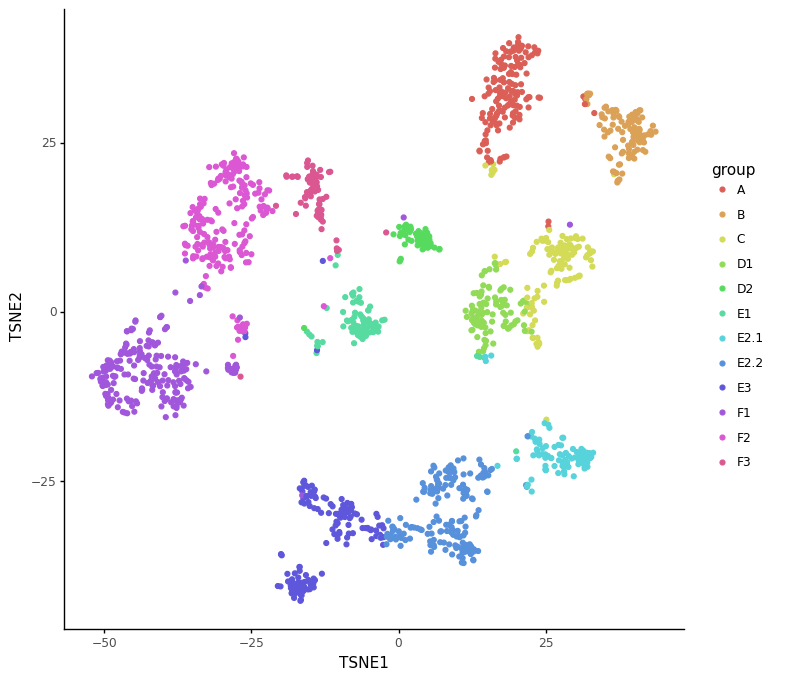

<ggplot: (8735037326461)>

In [18]:
dimRed_res_df = get_tsne(dis_mat, site_mat.index, seed=7371793,NCLUST=12)

# add "show_name" to make antibody names informative and consistent
bd45_names = pd.read_csv("data/BD45_names.csv", index_col=0)['name'].to_dict()

Ab_rename = {
    'BD45-54':"LY-CoV016", 'BD30-593':"DXP-593", 'BD30-604':'DXP-604', 
    'BD45-21':'BRII-196', 'S2K146_Bloom':"S2K146", 'CR3022_Bloom':'CR3022',
}

def parse_ab_show_name(name):
    if name in Ab_rename:
        return Ab_rename[name]
    if re.match(pattern='^BD30', string=name):
        return name[0:2]+name[4:]
    if re.match(pattern='^BD45', string=name):
        return bd45_names[name]
    if re.match(pattern='^BD55', string=name):
        _num = int(name.split('-')[1])
        if (_num < 300):
            return 'BD-'+str(_num+630)
        else:
            return name
    else:
        return name

dimRed_res_df = dimRed_res_df.assign(show_name = [parse_ab_show_name(x) for x in dimRed_res_df.index])

# adjust the direction of axis for beauty
dimRed_res_df['TSNE1'] = -dimRed_res_df['TSNE1']
dimRed_res_df['TSNE2'] = -dimRed_res_df['TSNE2']
dimRed_res_df.columns = ['TSNE2','TSNE1','group','show_name']

dimRed_res_df.to_csv("outputs/antibody_clusters.csv")

(
    ggplot(dimRed_res_df.reset_index(), aes(x='TSNE1', y='TSNE2'))+
        geom_point(aes(color='group'))+
        theme_classic()+
        theme(figure_size=(8, 8),aspect_ratio=1.0)
)

In [19]:
# assign cluster information to mut scores
use_res_min = use_res.assign(group=[dimRed_res_df.loc[x, 'group'] for x in use_res['antibody']])[['antibody','site','mutation','mut_escape','group']]

# calculate site mean/total scores
use_res_site = use_res_min.groupby(['antibody', 'site']).mean().assign(site_total=use_res_min.groupby(['antibody', 'site']).sum()['mut_escape']).reset_index()
use_res_site.columns = ['antibody', 'site', 'site_mean', 'site_total']

use_res_min.to_csv("outputs/use_abs_res.csv", index=None)
use_res_site.to_csv("outputs/use_abs_res_site.csv", index=None)

# calculate group mean site scores
(
    use_res_min.groupby(['antibody', 'site', 'group'])
               .sum().reset_index()
               .groupby(['group', 'site']).mean().reset_index()
               .to_csv('outputs/group_site_mean.csv', index=None)
)
# calculate group mean mut scores
group_ab_num = dimRed_res_df.groupby(['group']).count().iloc[:,0].to_dict()
_ = use_res_min.groupby(['site', 'group', 'mutation']).sum().reset_index()
_ = _.assign(group_ab_num = [group_ab_num[x] for x in _['group']])
_['mut_escape'] = _['mut_escape'] / _['group_ab_num']
# drop low signals
_.iloc[:,0:4].query('mut_escape > 0.03').to_csv('outputs/group_mut_mean.csv', index=None)


In [21]:
# All antibodies denoising
# drop scores less than 2*median for visualization

# **** time consuming ****
# Maybe you can just run this procedure for antibodies you're interested in.
# I believe there exists faster implementation, but I'm too lazy.

test_abs = np.unique(use_res['antibody']) # antibody list, you can change it!

use_res_clean = use_res.query('antibody in @test_abs')
use_site = use_res_clean.groupby(['antibody', 'site']).sum()
use_site_median = use_site.query('mut_escape > 0').reset_index().groupby(['antibody']).median()['mut_escape'].to_dict()
use_mut_median = use_res_clean.query('mut_escape > 0').groupby(['antibody']).median()['mut_escape'].to_dict()

use_site = use_site['mut_escape'].to_dict()

use_res_clean = use_res_clean.assign(site_total = [use_site[(use_res_clean.loc[x,]['antibody'],use_res_clean.loc[x,]['site'])] for x in use_res_clean.index],
                                         site_median = [use_site_median[use_res_clean.loc[x,]['antibody']] for x in use_res_clean.index],
                                         mut_median = [use_mut_median[use_res_clean.loc[x,]['antibody']] for x in use_res_clean.index],
                                         group = [dimRed_res_df.loc[x, 'group'] for x in use_res_clean['antibody']]).query('site_total > 2*site_median and mut_escape > 2*mut_median')
use_res_clean[['antibody', 'site', 'mutation', 'mut_escape', 'group']].to_csv('outputs/results_clean.csv', index=None)

In [22]:
import logomaker
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
rcParams['pdf.fonttype'] = 42

def plot_res_logo(res, prefix, shownames={}, rownames=None, site_thres=0.1, width=26):
    flat_res = res.pivot(index=['antibody', 'site'], columns='mutation', values='mut_escape').fillna(0)
    sites_mean_score = flat_res.mean(axis=1)
    sites_total_score = flat_res.sum(axis=1)
    _ = sites_total_score[sites_total_score>site_thres].index
    strong_sites = np.unique(np.array(sorted([i[1] for i in _])))
    
    print(prefix)
    # Omicron  BA.1 mut
    highlight = [339, 371, 373, 375, 417, 440, 446, 477, 478, 484, 493, 496, 498, 501, 505]
    # plot_sites = np.union1d(strong_sites, struc_interface)
    plot_sites = strong_sites
    plot_sites = plot_sites[plot_sites < 520].astype(int)
    print(plot_sites)
    flat_res = flat_res[flat_res.index.isin(plot_sites, level=1)]

    _ = pd.DataFrame(sites_total_score)
    _.columns = ['value']
    _['site'] = [i[1] for i in _.index]
    _['antibody'] = [i[0] for i in _.index]

    if rownames is not None:
        Abs = rownames
    else:
        Abs = np.unique([i[0] for i in flat_res.index])
    print(Abs)
    Npages = len(Abs)//10 + 1
    with PdfPages(prefix+'_aa_logo.pdf') as pdf:
        for p in range(Npages):
            Abs_p = Abs[p*10:min(len(Abs),(p+1)*10)]
            fig = plt.figure(figsize=(width,len(Abs_p)*4.6)).subplots_adjust(wspace=0.2,hspace=0.5)
            site2pos = {}
            for i in range(len(plot_sites)):
                site2pos[plot_sites[i]] = i

            for i in range(len(Abs_p)):
                ab = Abs_p[i]
                _ = flat_res.query('antibody == @ab').droplevel(0)
                add_sites = np.setdiff1d(plot_sites, _.index)
                for _site in add_sites:
                    _.loc[_site,:] = 0.0
                _ = _.sort_index()
                _.index = range(len(_))
                ax = plt.subplot(len(Abs_p), 1, i+1)
                logo = logomaker.Logo(_,
                               ax=ax, 
                               color_scheme='dmslogo_funcgroup', 
                               vpad=.1, 
                               width=.8)
                logo.style_xticks(anchor=0, spacing=1, rotation=90, fontsize=16)
                _max = np.sum(_.to_numpy(), axis=1).max()
                ax.yaxis.set_tick_params(labelsize=20)
                if _max < 3:
                    ax.set_ylim(0,3)
                    ax.set_yticks(range(0, 3, 1))
                elif _max < 5:
                    ax.set_yticks(range(0, int(_max)+1, 1))
                elif _max < 8:
                    ax.set_yticks(range(0, int(_max)+1, 2))
                else:
                    ax.set_yticks(range(0, int(_max)+1, 3))

                for ifsite in highlight:
                    if ifsite in plot_sites:
                        logo.highlight_position(p=site2pos[ifsite], color='gold', alpha=.2)
                if 346 in plot_sites:
                    logo.highlight_position(p=site2pos[346], color='red', alpha=.1)
                for ifsite in [376, 405, 408]:
                    if ifsite in plot_sites:
                        logo.highlight_position(p=site2pos[ifsite], color='blue', alpha=.1)

                ax.set_xticklabels(plot_sites)

                if ab in shownames:
                    ax.set_title(shownames[ab], fontsize=20, fontweight="bold")
                else:
                    ax.set_title(ab, fontsize=20, fontweight="bold")
            pdf.savefig()
            plt.close()

In [23]:
# generate logoplot for all antibodies
# use_res_clean = pd.read_csv("outputs/results_clean.csv")
for g in np.unique(use_res_clean['group']):
    plot_res_logo(use_res_clean.query('group == @g'), 'outputs/pdf/Group'+g, shownames=dimRed_res_df['show_name'].to_dict(),site_thres=0.1)

outputs/pdf/GroupA
[334 335 337 338 339 340 345 346 347 348 352 354 356 357 358 359 360 361
 362 363 365 366 367 369 370 371 374 375 376 377 378 382 384 385 386 388
 389 390 391 392 393 394 396 402 403 405 406 408 409 411 413 414 415 417
 420 421 427 428 430 434 439 440 441 443 444 445 446 447 448 449 450 453
 455 456 458 459 460 462 463 464 465 468 469 470 471 472 473 474 475 476
 477 478 479 480 481 482 483 484 485 486 487 489 490 491 493 494 496 498
 499 500 501 502 503 504 505 506 508 514 516 517 518 519]
['BD30-218' 'BD30-236' 'BD30-369' 'BD30-395' 'BD30-418' 'BD30-494'
 'BD30-498' 'BD30-500' 'BD30-503' 'BD30-504' 'BD30-505' 'BD30-507'
 'BD30-508' 'BD30-515' 'BD30-598' 'BD30-599' 'BD30-604' 'BD30-605'
 'BD30-612' 'BD30-613' 'BD30-614' 'BD30-616' 'BD30-618' 'BD30-619'
 'BD30-628' 'BD30-629' 'BD45-109' 'BD45-112' 'BD45-113' 'BD45-115'
 'BD45-122' 'BD45-123' 'BD45-142' 'BD45-146' 'BD45-154' 'BD45-157'
 'BD45-159' 'BD45-163' 'BD45-169' 'BD45-173' 'BD45-177' 'BD45-178'
 'BD45-186' 'BD4

In [20]:
# So ugly and redundant is these code

# Fig S6b OC v.s. WT ABC as an example
# See plot.R.ipynb for plot with MSA

neutral_data = pd.read_csv('data/Neutral_info.csv',index_col=0)
use_abs_res = pd.read_csv("outputs/use_abs_res.csv")

OC_A = neutral_data.query('group == "A" and source_group == "BA.1"').index
WT_A = neutral_data.query('group == "A" and source_group != "BA.1"').index
OC_B = neutral_data.query('group == "B" and source_group == "BA.1"').index
WT_B = neutral_data.query('group == "B" and source_group != "BA.1"').index
OC_C = neutral_data.query('group == "C" and source_group == "BA.1"').index
WT_C = neutral_data.query('group == "C" and source_group != "BA.1"').index

OC_A = use_abs_res.query('antibody in @OC_A').groupby(
    ['site','mutation','group']).mean().reset_index().assign(group='A from BA.1 covalescents')
WT_A = use_abs_res.query('antibody in @WT_A').groupby(
    ['site','mutation','group']).mean().reset_index().assign(group='A from others')
OC_B = use_abs_res.query('antibody in @OC_B').groupby(
    ['site','mutation','group']).mean().reset_index().assign(group='B from BA.1 covalescents')
WT_B = use_abs_res.query('antibody in @WT_B').groupby(
    ['site','mutation','group']).mean().reset_index().assign(group='B from others')
OC_C = use_abs_res.query('antibody in @OC_C').groupby(
    ['site','mutation','group']).mean().reset_index().assign(group='C from BA.1 covalescents')
WT_C = use_abs_res.query('antibody in @WT_C').groupby(
    ['site','mutation','group']).mean().reset_index().assign(group='C from others')

pd.concat([
    OC_A,
    WT_A,
    OC_B,
    WT_B,
    OC_C,
    WT_C
]).query('mut_escape>0.03').to_csv("outputs/FigS6b-ABC-WT-OC.csv", index=None)


In [24]:
# Fig 6e E1, F2, F3 (BA.2 neutralizing v.s. BA.2 escape)
# as another example
# See plot.R.ipynb for plot with MSA

neutral_data = pd.read_csv('data/Neutral_info.csv',index_col=0)
use_abs_res = pd.read_csv("outputs/use_abs_res.csv")

use_F2 = neutral_data.query('group == "F2" and BA2_IC50 < 2').index
use_F3 = neutral_data.query('group == "F3" and BA2_IC50 < 2').index

use_F2 = use_abs_res.query('antibody in @use_F2').groupby(
    ['site','mutation','group']).mean().reset_index().rename(columns={'group':'antibody'})
use_F3 = use_abs_res.query('antibody in @use_F3').groupby(
    ['site','mutation','group']).mean().reset_index().rename(columns={'group':'antibody'})
all_E1 = use_abs_res.query('group == "E1"').groupby(
    ['site','mutation','group']).mean().reset_index().rename(columns={'group':'antibody'})
all_F2 = use_abs_res.query('group == "F2"').groupby(
    ['site','mutation','group']).mean().reset_index().rename(columns={'group':'antibody'})
all_F3 = use_abs_res.query('group == "F3"').groupby(
    ['site','mutation','group']).mean().reset_index().rename(columns={'group':'antibody'})

use_F2['antibody'] = 'BA.2 Neutralizing F2'
use_F3['antibody'] = 'BA.2 Neutralizing F3'

pd.concat([
    all_E1,
    all_F2,
    all_F3,
    use_F2,
    use_F3
]).query('mut_escape>0.03').to_csv("outputs/Fig6e-F2F3.csv", index=None)
